In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import keras

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
CUDA available: True
CUDA device: Tesla T4


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {x_test.shape}, Labels: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


**Convert to PyTorch tensors**

In [4]:
x_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.LongTensor(y_train)

x_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.LongTensor(y_test)


print(f"Training set: {x_train_torch.shape}, Labels: {y_train_torch.shape}")
print(f"Test set: {x_test_torch.shape}, Labels: {y_test_torch.shape}")

Training set: torch.Size([60000, 28, 28]), Labels: torch.Size([60000])
Test set: torch.Size([10000, 28, 28]), Labels: torch.Size([10000])


**Create DataLoaders**

In [5]:
train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_dataset = TensorDataset(x_test_torch, y_test_torch)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 469
Number of test batches: 79


**Build Model**

In [7]:
class MNISTClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_unit=[128, 64], output_classes=10, dropout=0.25):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit[0])
        self.droput1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_unit[0], hidden_unit[1])
        self.droput2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_unit[1], output_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.droput1(x)
        x = F.relu(self.fc2(x))
        x = self.droput2(x)
        x = self.fc3(x)
        return x

In [8]:
model = MNISTClassifier(input_size=784, hidden_unit=[128, 64], output_classes=10)
print(model)

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (droput1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (droput2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


**Count parameters**

In [9]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 109,386
Trainable parameters: 109,386


**Move to GPU**

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pytorch = model.to(device)
print(f"Using device: {device}")

Using device: cuda


**Train Model**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

**Split validation set**

In [12]:
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

In [13]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

best_val_loss = float('inf')
patience_counter = 0
patience = 5

**Training**

In [15]:
num_epochs = 15
train_losses = []
val_losses = []
train_accs = []
val_accs = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        batch_x = batch_x.view(batch_x.size(0), -1)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()


    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            batch_x = batch_x.view(batch_x.size(0), -1)

            outputs= model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()


    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_loss)


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model_pytorch.load_state_dict(torch.load('best_model.pth'))
            break


    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/15:
  Train Loss: 0.7642, Train Acc: 80.28%
  Val Loss: 0.2270, Val Acc: 93.78%
  LR: 0.001000
Epoch 2/15:
  Train Loss: 0.3103, Train Acc: 91.13%
  Val Loss: 0.1811, Val Acc: 94.83%
  LR: 0.001000
Epoch 3/15:
  Train Loss: 0.2494, Train Acc: 92.77%
  Val Loss: 0.1637, Val Acc: 95.33%
  LR: 0.001000
Epoch 4/15:
  Train Loss: 0.2189, Train Acc: 93.70%
  Val Loss: 0.1373, Val Acc: 96.09%
  LR: 0.001000
Epoch 5/15:
  Train Loss: 0.1917, Train Acc: 94.41%
  Val Loss: 0.1360, Val Acc: 96.08%
  LR: 0.001000
Epoch 6/15:
  Train Loss: 0.1721, Train Acc: 95.00%
  Val Loss: 0.1353, Val Acc: 96.17%
  LR: 0.001000
Epoch 7/15:
  Train Loss: 0.1697, Train Acc: 95.10%
  Val Loss: 0.1280, Val Acc: 96.46%
  LR: 0.001000
Epoch 8/15:
  Train Loss: 0.1602, Train Acc: 95.31%
  Val Loss: 0.1366, Val Acc: 96.03%
  LR: 0.001000
Epoch 9/15:
  Train Loss: 0.1488, Train Acc: 95.56%
  Val Loss: 0.1288, Val Acc: 96.33%
  LR: 0.001000
Epoch 10/15:
  Train Loss: 0.1445, Train Acc: 95.66%
  Val Loss: 0.1246, 

In [17]:
model_pytorch.load_state_dict(torch.load('best_model.pth'))
model_pytorch.eval()

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (droput1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (droput2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [19]:
test_loss_pytorch = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        batch_x = batch_x.view(batch_x.size(0), -1)

        outputs = model_pytorch(batch_x)
        loss = criterion(outputs, batch_y)

        test_loss_pytorch += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_loss_pytorch /= len(test_loader)
test_acc_pytorch = 100 * test_correct / test_total

print(f"\nPyTorch Model Results:")
print(f"Test Loss: {test_loss_pytorch:.4f}")
print(f"Test Accuracy: {test_acc_pytorch:.2f}%")


PyTorch Model Results:
Test Loss: 0.1026
Test Accuracy: 97.40%


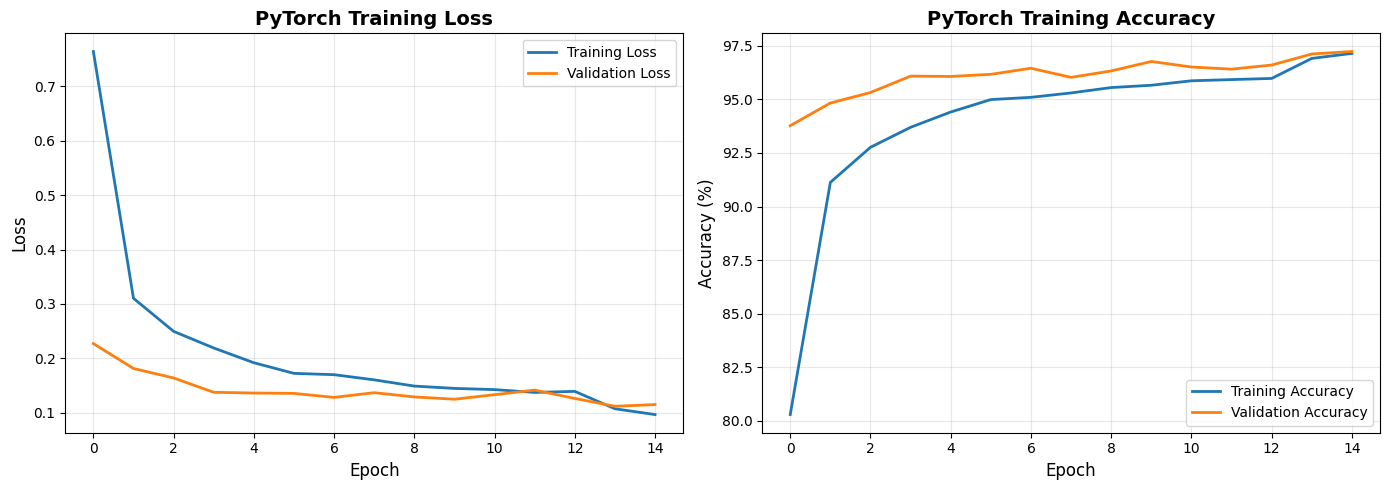

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('PyTorch Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('PyTorch Training Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
model_pytorch.eval()
with torch.no_grad():
    test_samples = x_test_torch[:10].to(device)
    test_samples = test_samples.view(test_samples.size(0), -1)
    predictions_pytorch = model_pytorch(test_samples)
    predicted_probs_pytorch = F.softmax(predictions_pytorch, dim=1)
    predicted_classes_pytorch = torch.argmax(predicted_probs_pytorch, dim=1).cpu().numpy()


for i in range(10):
    print(f"  Image {i}: True={y_test[i]}, Predicted={predicted_classes_pytorch[i]}, "
          f"Confidence={predicted_probs_pytorch[i][predicted_classes_pytorch[i]]:.3f}")

  Image 0: True=7, Predicted=7, Confidence=1.000
  Image 1: True=2, Predicted=2, Confidence=0.999
  Image 2: True=1, Predicted=1, Confidence=1.000
  Image 3: True=0, Predicted=0, Confidence=1.000
  Image 4: True=4, Predicted=4, Confidence=1.000
  Image 5: True=1, Predicted=1, Confidence=1.000
  Image 6: True=4, Predicted=4, Confidence=1.000
  Image 7: True=9, Predicted=9, Confidence=0.994
  Image 8: True=5, Predicted=6, Confidence=0.581
  Image 9: True=9, Predicted=9, Confidence=1.000
